# Notebook on Keras/Tensorflow Convolutional Neural Networks (CNN) Modeling for Images

By Dane Morgan with almost all materials taken from others. We will build a CNN for the American Sign Language dataset (images of hands making letters in [American Sign Language](http://www.asl.gs/)).
* Most taken from [Nvidia Deep Learning course](https://www.nvidia.com/en-us/training/).

Learning goal(s):
* Be able to build a CNN and train and aseess it using Keras/Tensorflow.
* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance




In the previous part of this module (previous "exercise") we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

# Colab setup

## GPUs
This lab is much faster on GPUs/TPUs. Make sure you are using GPUs or TPUs by doing the following:
* Enabling GPU. To enable GPU in your notebook, (i) Edit/Notebook Settings, or (ii) select the following menu options − Runtime / Change runtime type. See which works.
* Testing for GPU. You can easily check if the GPU is enabled by executing the following code:

In [ ]:
# Test if running GPU
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, modify the path where you saved this notebook and the associated lab files on your Google drive, if different from below (this is an example Dane Morgan had for class)

In [ ]:
path = '/content/drive/MyDrive/Colab Stuff/MSE_803_Lab5_Dev_23/Lab'
#path = '/content/drive/MyDrive/Online Filed/Dane Morgan Mixed Sharing/Projects/Courses/MSE803 F22/Dane student view/MSE803_Lab1'

Check the path name is assigned correctly.

In [ ]:
!echo $path
import os
os.path.isdir(path)


/content/drive/MyDrive/Colab Stuff/MSE_803_Lab5_Dev_23/Lab


True

In [ ]:
# This is needed so can import packages from a different path than standard libraries
import sys
sys.path.append(path)

# Some useful functions

In [ ]:
# This plots scores for training and validation data vs. epoch.
def err_plot(acc, val_acc, loss, val_loss):
  import matplotlib.pyplot as plt

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



# Loading and Preparing the Data

## Setting up the Data
This dataset is not available via Keras in the same way that some data sets are (e.g., MNIST). This dataset is available from the website [Kaggle](http://www.kaggle.com), which is a fantastic place to find datasets and other deep learning resources. In addition to providing resources like datasets and "kernels" that are like these notebooks, Kaggle hosts competitions that you can take part in, competing with others in training highly accurate models.

If you're looking to practice or see examples of many deep learning projects, Kaggle is a great site to visit.

We will be learning to classify images into letters in the American Sign Language Alphabet (ASL). The [ASL alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset. We display the images below.

Loading image from:  /content/drive/MyDrive/Colab Stuff/MSE_803_Lab5_Dev_23/Lab/images/asl.png


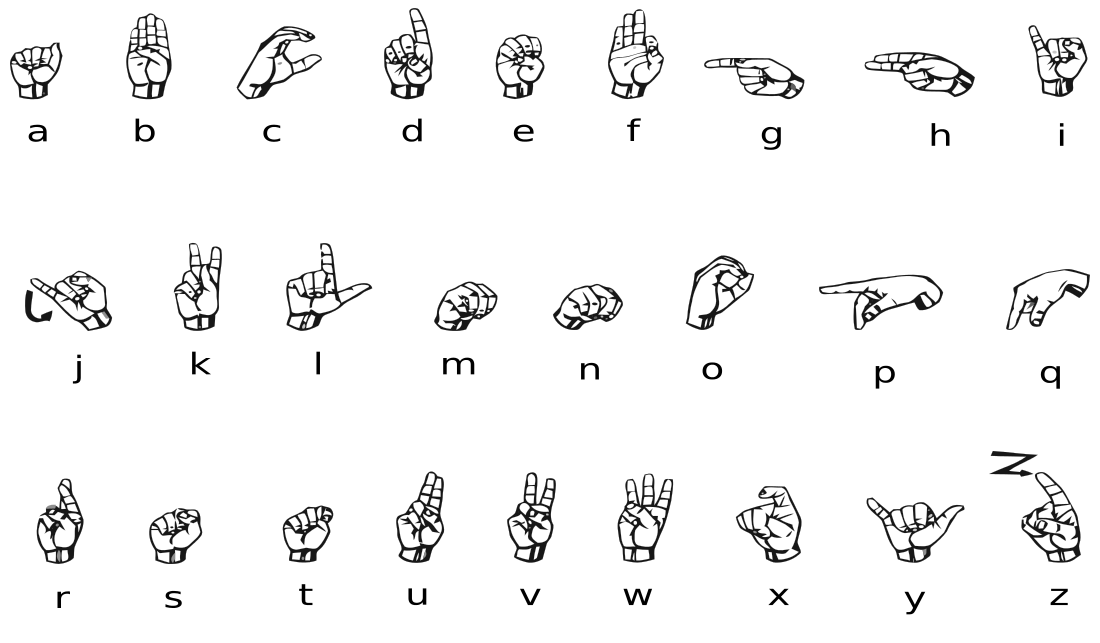

In [ ]:
from IPython.display import Image
filename = os.path.join(path, 'images/asl.png')
print('Loading image from: ',filename)
display(Image(filename, width=600))

The below cell contains the data preprocessing techniques we learned in the previous exercise.

In [ ]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv(os.path.join(path, 'data/asl_data/sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(path, 'data/asl_data/sign_mnist_valid.csv'))

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## Reshaping Images for a CNN

In the last exercise, the individual pictures in our dataset are in the format of long lists of 784 pixels:

In [ ]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [ ]:
x_train.shape

(27455, 28, 28, 1)

In [ ]:
x_valid.shape

(7172, 28, 28, 1)

In [ ]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

# Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [stackoverflow](https://stackoverflow.com/)). NOTE - GET DATA, IMAGE folders and use them in both labs HERE???

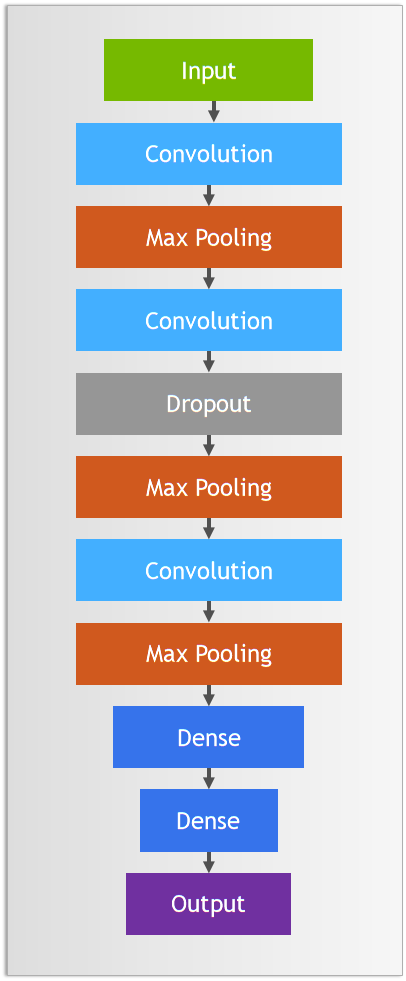

In [ ]:
filename = os.path.join(path, 'images/cnn.png')
display(Image(filename, width=200))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

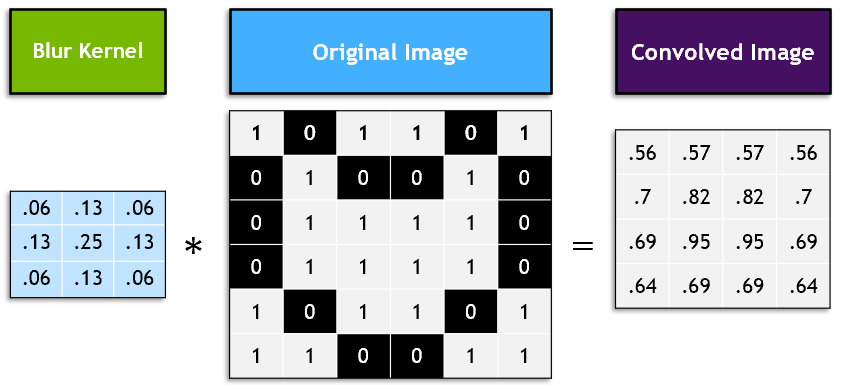

In [ ]:
filename = os.path.join(path, 'images/conv2d.png')
display(Image(filename, width=400))


### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

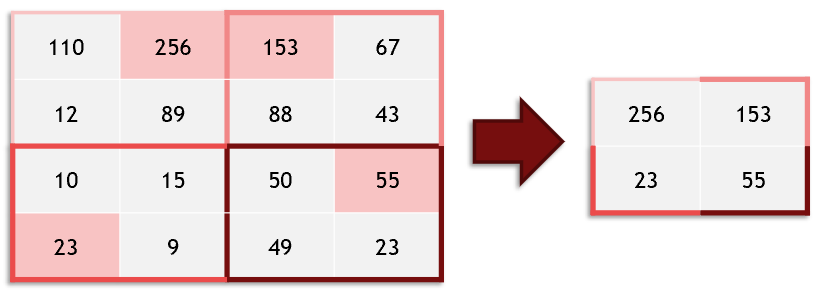

In [ ]:
filename = os.path.join(path, 'images/maxpool2d.png')
display(Image(filename, width=400))

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

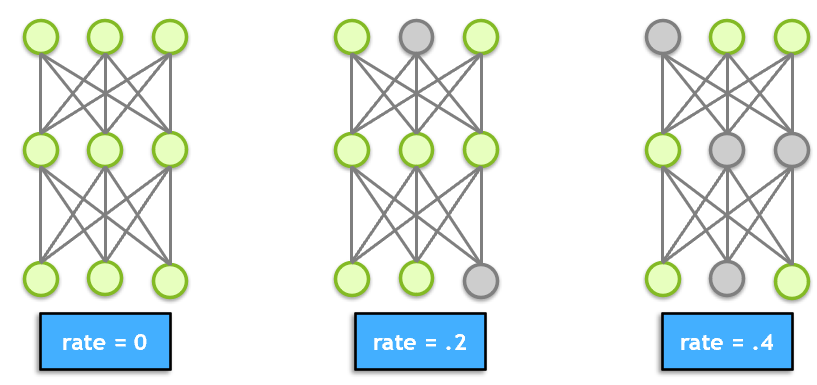

In [ ]:
filename = os.path.join(path, 'images/dropout.png')
display(Image(filename, width=400))

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created. Notice how it has fewer trainable parameters than the model in the previous notebook:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

## Compiling the Model

We'll compile the model just like before:

In [ ]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Training the Model

Despite the very different model architecture, the training looks exactly the same. Run the cell below to train for 20 epochs and let's see if the accuracy improves (~ 3 min):

In [ ]:
hist=model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
858/858 [==============================] - 21s 12ms/step - loss: 0.3049 - accuracy: 0.9058 - val_loss: 0.3764 - val_accuracy: 0.8809
Epoch 2/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.3018 - val_accuracy: 0.9049
Epoch 3/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.2798 - val_accuracy: 0.9345
Epoch 4/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.2958 - val_accuracy: 0.9320
Epoch 5/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.1665 - val_accuracy: 0.9554
Epoch 6/20
858/858 [==============================] - 7s 8ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.2230 - val_accuracy: 0.9578
Epoch 7/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2954 - val_accuracy: 0.9239
Epoc

## Analyze Model Results

In [ ]:
# See what data we have saved in history from model run
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


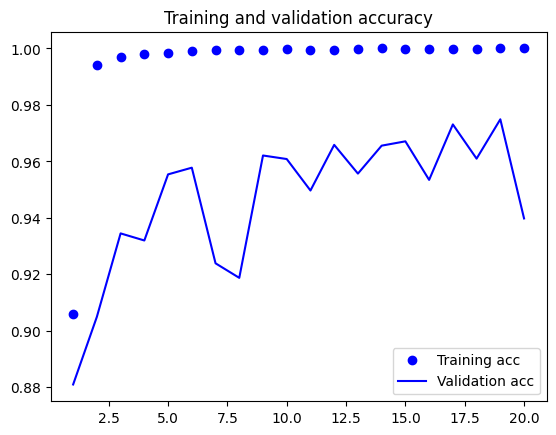

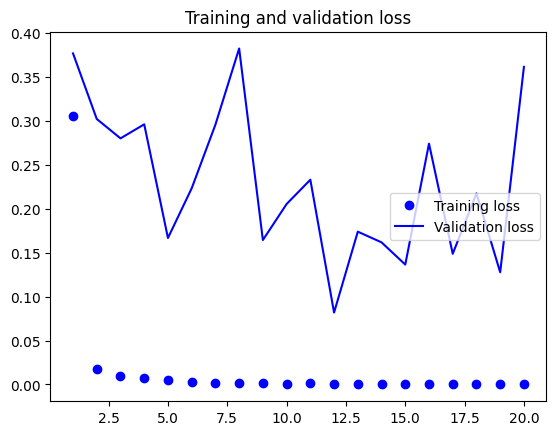

In [ ]:
# Plot accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

err_plot(acc,val_acc,loss,val_loss)

In [ ]:
# Output top accuracy in validation data
max_acc = max(hist.history['val_accuracy'])
maxacc_index = hist.history['val_accuracy'].index(max_acc)+1
print("Best validation accuracy during run was: %1.2f on epoch %i"
      % (max_acc, maxacc_index))

Best validation accuracy during run was: 0.97 on epoch 19


## Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do with data augmentation if you want to explore that.

# Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

# Question 1
Construct a much simpler architecture and compare error to above. Provide a plot of train and validation accuracy and give value of best value from this CNN vs. above CNN. Just do one block of Conv2D, Normalization, MaxPool, dropout, and then feed directly into the dense NN.

Question 1 solution

# Question 2
There are a number of specific choices in the network used in this exercidse whose importance is hard for me to assess. To explore this, try setting all the strides to 2 in our original architecture and rerunning.  Provide a plot of train and validation accuracy and give value of best value from this CNN vs. above CNN.

Question 2 solution